## Modelbuilder
This notebook presents the basic features of the modelbuilder proof of concept. It generates a D-Flow Flexible Mesh model from scratch with only a lat/lon box as input. Since this is a proof of concept, many functions/inputs will change in the future but this notebook will be updated accordingly.

A more advanced example of model building is available at: 
https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_modelbuilder.py


In [1]:
# import packages
import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
import hydrolib.core.dflowfm as hcdfm
import xarray as xr
import pandas as pd
import numpy as np
import contextily as ctx


In [2]:
# user input
model_name = 'Vietnam'
dir_output = os.path.abspath(f'./{model_name}_model')
# path_style = 'windows' # windows / unix
overwrite = True # used for downloading of forcing data. Always set to True when changing the domain
is_geographic = True # spherical (True) or cartesian (False) coordinates
crs = 'EPSG:4326' # coordinate reference system

# domain and resolution
if model_name=='Bonaire':
    lon_min, lon_max, lat_min, lat_max = -68.55, -67.9, 11.8, 12.6
elif model_name=='Vietnam':
    lon_min, lon_max, lat_min, lat_max = 105.8, 106.85, 17.75, 18.5
dxy = 0.05
buffer = 0.01 # old Vietnam buffers: 0.06 for CMEMS, 0.12 for EOT20, 0.17 for tpxo80

#dates as understood by pandas.period_range(). ERA5 has freq='M' (month) and CMEMS has freq='D' (day)
date_min = '2022-11-01'
date_max = '2022-11-03'
ref_date = '2022-01-01'


In [3]:
# make directories and list all files
os.makedirs(dir_output, exist_ok=True)
dir_output_data = os.path.join(dir_output, 'data')
os.makedirs(dir_output_data, exist_ok=True)
os.listdir(dir_output)

['data',
 'DFM_OUTPUT_Vietnam',
 'dimr_config.xml',
 'era5_msl_u10n_v10n_chnk_20221101to20221103_ERA5.nc',
 'run_parallel.bat',
 'salinitybnd_Vietnam_CMEMS.bc',
 'temperaturebnd_Vietnam_CMEMS.bc',
 'tide_Vietnam_tpxo80_opendap.bc',
 'unstruc.dia',
 'uxuyadvectionvelocitybnd_Vietnam_CMEMS.bc',
 'Vietnam.mdu',
 'Vietnam.pli',
 'Vietnam_net.nc',
 'Vietnam_new.ext',
 'Vietnam_obs.xyn',
 'Vietnam_old.ext',
 'waterlevelbnd_Vietnam_CMEMS.bc']

## Grid generation and refinement with meshkernelpy

Another notebook with more grid generation details exposed (at the MeshkernelPy Github): https://github.com/Deltares/MeshKernelPy/blob/main/docs/examples/06_mesh2d_refinement_gridded_samples_gebco.ipynb

Another more advanced example of grid generation is available at: 
https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_meshkernel_creategrid.py


>> reading coastlines: 1.33 sec
>> reading coastlines: 1.08 sec


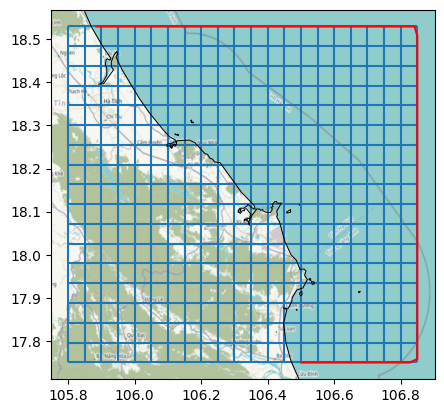

In [4]:
# generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min, lon_max, lat_min, lat_max, dx=dxy, dy=dxy, is_geographic=is_geographic)

# generate plifile from grid extent and coastlines
bnd_gdf = dfmt.generate_bndpli_cutland(mk=mk_object, res='h', buffer=buffer)
bnd_gdf['name'] = f'{model_name}_bnd'
bnd_gdf_interp = dfmt.interpolate_bndpli(bnd_gdf,res=0.03)
poly_file = os.path.join(dir_output, f'{model_name}.pli')
pli_polyfile = dfmt.geodataframe_to_PolyFile(bnd_gdf_interp)
pli_polyfile.save(poly_file)

# plot basegrid and polyline
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
bnd_gdf_interp.plot(ax=ax, edgecolor='r')
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 1.22 sec


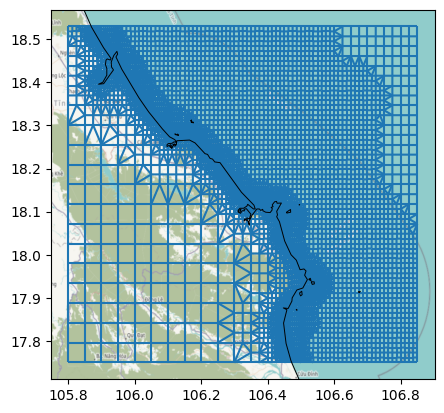

In [5]:
# connect to a coarse version of the GEBCO_2022 dataset on OPeNDAP
# alternatively download your own cutout from https://download.gebco.net (use a buffer of e.g. 1 degree)
file_gebco = f'https://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files/GEBCO_2022/GEBCO_2022_coarsefac08.nc'
data_bathy_sel = xr.open_dataset(file_gebco).sel(lon=slice(lon_min-1,lon_max+1),lat=slice(lat_min-1,lat_max+1))

# refine grid
min_edge_size = 300 # in meters
dfmt.refine_basegrid(mk=mk_object, data_bathy_sel=data_bathy_sel, min_edge_size=min_edge_size)

# plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 1.07 sec
>> reading coastlines: 1.26 sec


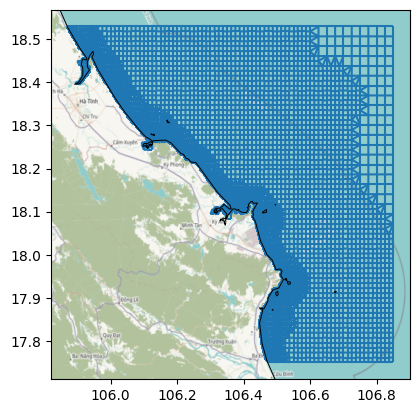

In [6]:
# remove land with GSHHS coastlines
dfmt.meshkernel_delete_withcoastlines(mk=mk_object, res='h')

# plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 1.20 sec


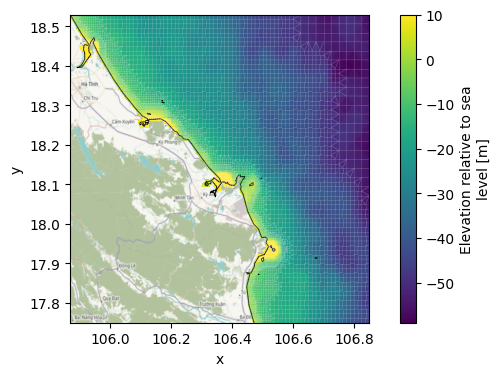

In [7]:
# convert to xugrid
xu_grid_uds = dfmt.meshkernel_to_UgridDataset(mk=mk_object, crs=crs)

# interpolate bathymetry onto the grid
data_bathy_interp = data_bathy_sel.interp(lon=xu_grid_uds.obj.mesh2d_node_x, lat=xu_grid_uds.obj.mesh2d_node_y).reset_coords(['lat','lon'])
xu_grid_uds['mesh2d_node_z'] = data_bathy_interp.elevation.clip(max=10)

# plot bathymetry and grid
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.mesh2d_node_z.ugrid.plot(ax=ax,center=False)
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='white',alpha=0.2)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

# write xugrid grid to netcdf
netfile = os.path.join(dir_output, f'{model_name}_net.nc')
xu_grid_uds.ugrid.to_netcdf(netfile)


## Generate boundary conditions from tidal model and CMEMS (new format .ext)

In [8]:
# generate new format external forcings file (.ext): initial and open boundary condition
ext_file_new = os.path.join(dir_output, f'{model_name}_new.ext')
ext_new = hcdfm.ExtModel()


In [9]:
# interpolate tidal components to boundary conditions file (.bc)
tidemodel = 'tpxo80_opendap' # tidemodel: FES2014, FES2012, EOT20, GTSMv4.1, GTSMv4.1_opendap
ForcingModel_object = dfmt.interpolate_tide_to_bc(tidemodel=tidemodel, file_pli=poly_file, component_list=None)
file_bc_out = os.path.join(dir_output,f'tide_{model_name}_{tidemodel}.bc')
ForcingModel_object.save(filepath=file_bc_out)
boundary_object = hcdfm.Boundary(quantity='waterlevelbnd',
                                 locationfile=poly_file,
                                 forcingfile=ForcingModel_object)
ext_new.boundary.append(boundary_object)


> interp mfdataset to all PolyFile points (lat/lon coordinates)
> actual extraction of data from netcdf with .load() (for 71 plipoints at once, this might take a while)
>>time passed: 0.00 sec
Converting 71 plipoints to hcdfm.ForcingModel(): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71. >> done in 0.14 sec


In [10]:
# CMEMS - download spatial fields of salinity, temperature, currents and sea surface height
dir_output_data_cmems = os.path.join(dir_output_data, 'cmems')
os.makedirs(dir_output_data_cmems, exist_ok=True)
for varkey in ['so','thetao','uo','vo','zos']:
    dfmt.download_CMEMS(varkey=varkey,
                        longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                        date_min=date_min, date_max=date_max,
                        dir_output=dir_output_data_cmems, file_prefix='cmems_', overwrite=overwrite)

# CMEMS - boundary conditions file (.bc) and add to ext_bnd
list_quantities = ['waterlevelbnd','salinitybnd','temperaturebnd','uxuyadvectionvelocitybnd']
ext_new = dfmt.cmems_nc_to_bc(ext_bnd=ext_new,
                              refdate_str=f'minutes since {ref_date} 00:00:00 +00:00',
                              dir_output=dir_output,
                              list_quantities=list_quantities,
                              tstart=date_min,
                              tstop=date_max, 
                              file_pli=poly_file,
                              dir_pattern=os.path.join(dir_output_data_cmems,'cmems_{ncvarname}_*.nc'))

#save new ext file
ext_new.save(filepath=ext_file_new) # ,path_style=path_style)


retrieving time range of CMEMS reanalysis and forecast products
opening pydap connection to opendap dataset and opening with xarray: https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_my_0.083_P1D-m.html
found CMEMS credentials
opening pydap connection to opendap dataset and opening with xarray: https://nrt.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_anfc_0.083deg_P1D-m.html
The CMEMS 'analysisforecast' product will be used.
opening pydap connection to opendap dataset and opening with xarray: https://nrt.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy-so_anfc_0.083deg_P1D-m.html
xarray subsetting data (variable 'so' and lon/lat extents)
available time range in dataset from 2020-11-01 12:00:00 to 2023-10-27 12:00:00
xarray subsetting data per <Day>: 2022-10-31
xarray writing netcdf file: cmems_so_2022-10-31.nc
xarray subsetting data per <Day>: 2022-11-01
xarray writing netcdf file: cmems_so_2022-11-01.nc
xarray subsetting data per <Day>: 2022-11-02
xarray writing netcdf file: cmems_so_2

>> reading coastlines: 1.08 sec
>> reading coastlines: 1.05 sec


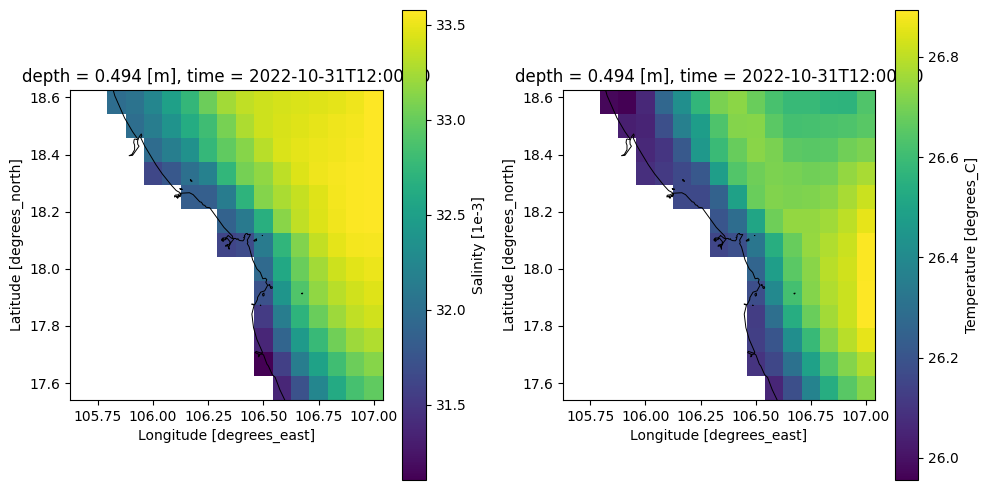

In [11]:
# plot downloaded CMEMS data
file_cmems = os.path.join(dir_output_data,'cmems','*.nc')
ds_cmems = xr.open_mfdataset(file_cmems)
ds_cmems

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_cmems.so.isel(time=0,depth=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_cmems.thetao.isel(time=0,depth=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


(-58.96910790071473, 0.02965003252029419)

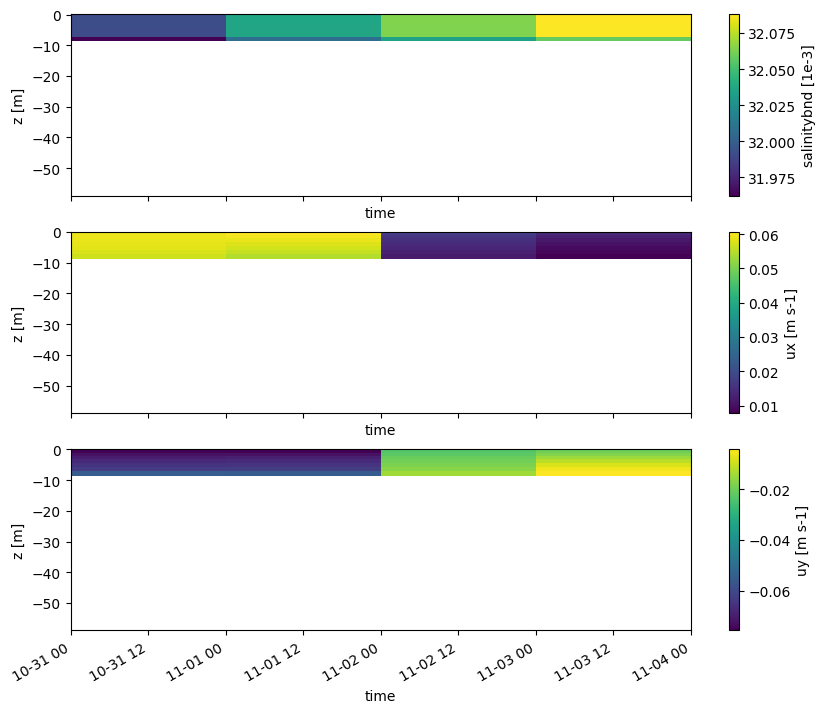

In [12]:
# plot interpolated CMEMS data (boundary conditions in .bc)
file_bc_sal = os.path.join(dir_output,f'salinitybnd_{model_name}_CMEMS.bc')
bc_obj_sal = hcdfm.ForcingModel(file_bc_sal)
forcing_xr_sal = dfmt.forcinglike_to_Dataset(bc_obj_sal.forcing[0], convertnan=True)

file_bc_uxuy = os.path.join(dir_output,f'uxuyadvectionvelocitybnd_{model_name}_CMEMS.bc')
bc_obj_uxuy = hcdfm.ForcingModel(file_bc_uxuy)
forcing_xr_uxuy = dfmt.forcinglike_to_Dataset(bc_obj_uxuy.forcing[0], convertnan=True)

# plot
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,8))
forcing_xr_sal['salinitybnd'].T.plot(ax=ax1)
forcing_xr_uxuy['ux'].T.plot(ax=ax2)
forcing_xr_uxuy['uy'].T.plot(ax=ax3)
ax1.set_ylim(xu_grid_uds.mesh2d_node_z.min(),None)

## Generate ERA5 meteo forcing (old ext)

In [13]:
# generate old format external forcings file (.ext): spatial data
ext_file_old = os.path.join(dir_output, f'{model_name}_old.ext')
ext_old = hcdfm.ExtOldModel()

# ERA5 - download spatial fields of air pressure, wind speeds and Charnock coefficient
dir_output_data_era5 = os.path.join(dir_output_data,'ERA5')
os.makedirs(dir_output_data_era5, exist_ok=True)
    
varlist_list = [['msl','u10n','v10n','chnk']]

for varlist in varlist_list:
    for varkey in varlist:
        dfmt.download_ERA5(varkey, 
                           longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                           date_min=date_min, date_max=date_max,
                           dir_output=dir_output_data_era5, overwrite=overwrite)

# ERA5 meteo - convert to netCDF for usage in Delft3D FM
ext_old = dfmt.preprocess_merge_meteofiles_era5(ext_old=ext_old,
                                                varkey_list = varlist_list,
                                                dir_data = dir_output_data_era5,
                                                dir_output = dir_output,
                                                time_slice = slice(date_min, date_max))

ext_old.save(filepath=ext_file_old) # ,path_style=path_style)


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "msl" and month 2022-11 (YYYY-MM)


2023-10-18 22:46:49,303 INFO Welcome to the CDS
2023-10-18 22:46:49,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-10-18 22:46:49,410 INFO Request is completed
2023-10-18 22:46:49,411 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data6/adaptor.mars.internal-1697653394.5524235-18169-9-55943ff4-cbd0-4d86-84fb-64f8ebbea05e.nc to c:\DATA\dfm_tools\docs\notebooks\Vietnam_model\data\ERA5\era5_msl_2022-11.nc (63K)
2023-10-18 22:46:49,893 INFO Download rate 130.9K/s                                                                    
2023-10-18 22:46:49,973 INFO Welcome to the CDS
2023-10-18 22:46:49,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-10-18 22:46:50,090 INFO Request is completed
2023-10-18 22:46:50,091 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/adaptor.mars.intern

found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "u10n" and month 2022-11 (YYYY-MM)


2023-10-18 22:46:50,617 INFO Download rate 119.9K/s                                                                    
2023-10-18 22:46:50,699 INFO Welcome to the CDS
2023-10-18 22:46:50,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "v10n" and month 2022-11 (YYYY-MM)


2023-10-18 22:46:50,870 INFO Request is completed
2023-10-18 22:46:50,870 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data5/adaptor.mars.internal-1697653564.6464314-2368-17-ae8c1414-ec05-4a24-b540-9cdcf5ad60c1.nc to c:\DATA\dfm_tools\docs\notebooks\Vietnam_model\data\ERA5\era5_v10n_2022-11.nc (63K)
2023-10-18 22:46:51,330 INFO Download rate 137.2K/s                                                                    
2023-10-18 22:46:51,411 INFO Welcome to the CDS
2023-10-18 22:46:51,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "chnk" and month 2022-11 (YYYY-MM)


2023-10-18 22:46:51,615 INFO Request is completed
2023-10-18 22:46:51,616 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data4/adaptor.mars.internal-1697653639.6121464-32641-1-eb6c6491-9efc-4f56-98c9-b488fd1b5a87.nc to c:\DATA\dfm_tools\docs\notebooks\Vietnam_model\data\ERA5\era5_chnk_2022-11.nc (63K)
2023-10-18 22:46:52,065 INFO Download rate 140.5K/s                                                                    


>> opening multifile dataset of 4 files (can take a while with lots of files): 0.04 sec
>> writing file (can take a while): 0.57 sec


>> reading coastlines: 1.29 sec
>> reading coastlines: 1.09 sec


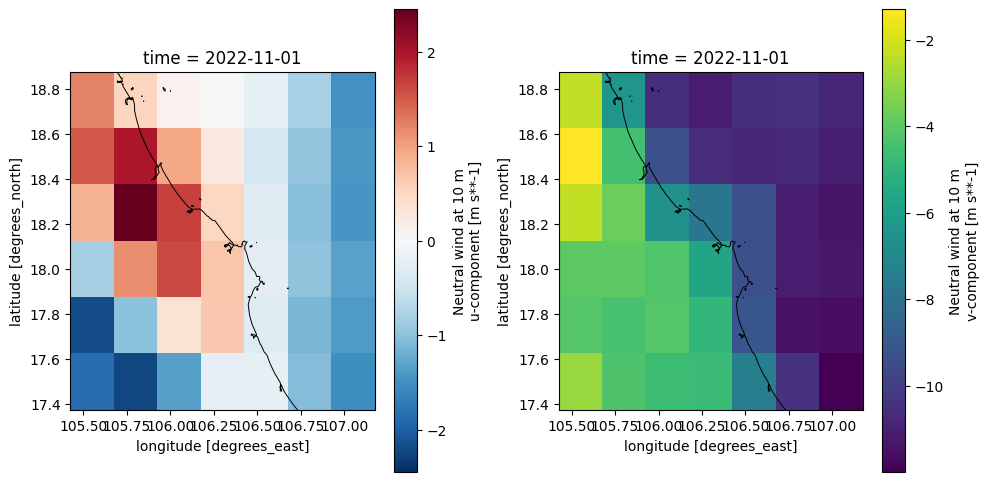

In [14]:
# plot converted ERA5 data
file_era5 = os.path.join(dir_output,'data','ERA5','*.nc')
ds_era5 = xr.open_mfdataset(file_era5)
ds_era5

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_era5.u10n.isel(time=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_era5.v10n.isel(time=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


## Generate obsfile

               x          y            name
1728  106.693750  18.386904  x106p69_y18p39
5603  106.489063  17.892349  x106p49_y17p89
3449  106.718751  18.089018  x106p72_y18p09
1604  106.762501  18.289613  x106p76_y18p29
1680  106.093750  18.386904  x106p09_y18p39
5750  106.464064  18.010107  x106p46_y18p01
2350  106.693750  18.329684  x106p69_y18p33
4318  106.315626  18.183632  x106p32_y18p18
5984  106.257813  18.219449  x106p26_y18p22
1661  106.693750  18.341132  x106p69_y18p34
>> reading coastlines: 1.12 sec


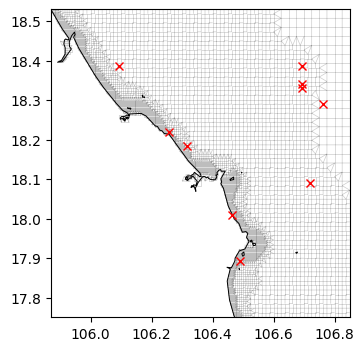

In [15]:
# generate obspoints on all grid faces
xpts = xu_grid_uds.grid.face_x
ypts = xu_grid_uds.grid.face_y
npts = [f'x{x:.2f}_y{y:.2f}'.replace('.','p') for x,y in zip(xpts,ypts)]
obs_pd = pd.DataFrame(dict(x=xpts,y=ypts,name=npts))

# subselect n arbitary obspoints and plot
n = 10
ipts = np.random.randint(0, len(obs_pd), n)
obs_pd = obs_pd.iloc[ipts]
print(obs_pd)
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='k',alpha=0.2)
ax.plot(obs_pd['x'],obs_pd['y'],'rx')
dfmt.plot_coastlines(ax=ax, crs=crs)

# save obsfile
file_obs = os.path.join(dir_output, f'{model_name}_obs.xyn')
obs_pd.to_csv(file_obs, sep=' ', header=False, index=False, float_format='%.6f')


## Generate mdu file

In [16]:
# initialize mdu file and update settings
mdu_file = os.path.join(dir_output, f'{model_name}.mdu')
mdu = hcdfm.FMModel()

# add the grid (_net.nc, network file)
mdu.geometry.netfile = netfile

# add the external forcing files (.ext)
mdu.external_forcing.extforcefile = ext_file_old
mdu.external_forcing.extforcefilenew = ext_new

# update time settings
mdu.time.refdate = pd.Timestamp(ref_date).strftime('%Y%m%d')
mdu.time.tunit = 'S'
mdu.time.dtmax = 30
mdu.time.startdatetime = pd.Timestamp(date_min).strftime('%Y%m%d%H%M%S')
mdu.time.stopdatetime = pd.Timestamp(date_max).strftime('%Y%m%d%H%M%S')
mdu.time.autotimestep = 3

# update output settings
mdu.output.obsfile = file_obs
mdu.output.hisinterval = [60]
mdu.output.mapinterval = [1800]#[86400]
mdu.output.rstinterval = [0]
mdu.output.statsinterval = [3600]

# save .mdu file
mdu.save(mdu_file) # ,path_style=path_style)


## Generate DIMR and bat file

In [17]:
file_dimr = os.path.join(dir_output,'dimr_config.xml')
nproc = 2 # number of processes
dimrset_folder = r"c:\Program Files\Deltares\Delft3D FM Suite 2023.03 HMWQ\plugins\DeltaShell.Dimr\kernels" #alternatively r"p:\d-hydro\dimrset\weekly\2.25.17.78708"
dfmt.create_model_exec_files(file_dimr, file_mdu=mdu_file, model_name=model_name, nproc=nproc, dimrset_folder=dimrset_folder)


writing c:\DATA\dfm_tools\docs\notebooks\Vietnam_model\dimr_config.xml
re-writing c:\DATA\dfm_tools\docs\notebooks\Vietnam_model\dimr_config.xml
writing c:\DATA\dfm_tools\docs\notebooks\Vietnam_model\run_parallel.bat


## Check written files in model directory

In [18]:
# list all files
os.listdir(dir_output)

['data',
 'DFM_OUTPUT_Vietnam',
 'dimr_config.xml',
 'era5_msl_u10n_v10n_chnk_20221101to20221103_ERA5.nc',
 'run_parallel.bat',
 'salinitybnd_Vietnam_CMEMS.bc',
 'temperaturebnd_Vietnam_CMEMS.bc',
 'tide_Vietnam_tpxo80_opendap.bc',
 'unstruc.dia',
 'uxuyadvectionvelocitybnd_Vietnam_CMEMS.bc',
 'Vietnam.mdu',
 'Vietnam.pli',
 'Vietnam_net.nc',
 'Vietnam_new.ext',
 'Vietnam_obs.xyn',
 'Vietnam_old.ext',
 'waterlevelbnd_Vietnam_CMEMS.bc']

# Exercises

After running the model generated above, the postprocessing notebook can be used to visualize your his and map output. Additionally, you can change the model input above and rerun the model builder and the model. It might be useful to check the [D-Flow FM manual](https://content.oss.deltares.nl/delft3d/D-Flow_FM_User_Manual.pdf) for background information. Some suggestions for model changes:
- change/extend the model simulation period
- create a new model_name and corresponding domain (use an area of approximately 1x1 degrees for a quick test)
- apply more/less refinement to the grid
- the observation points are randomly generated, add obspoints near actual cities/harbours/islands instead
- add a observation cross-section near a harbour or river
- add river inflow as a boundary condition (.pli and .bc in new format .ext or .pli and .tim in old format .ext)
- convert this 2D model into a 3D model
- enable the computation of salinity and temperature in the mdu (salinity=1 and temperature=5)
- use the fourier smoothing time (tlfSmo) to make the model spinup less chaotic
- try decreasing/increasing the buffer for the boundary pli. It is currently quite large for Vietnam since the used tide dataset lacks coverage near the coast.


# 